# Data Preparation & Exploration 

In [1]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%pylab inline
from datetime import datetime
import pickle 
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
import shap

pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
TODO = 20000
train = pd.read_pickle("train_set.pickle").sample(n=TODO)
train.loc[:,"clicked"] = train.loc[:,"clicked"].map({True:1, False:0})


In [4]:
def add_features(df):

    df.loc[:,'time'] = pd.to_datetime(df['timestamp'], unit='s')
    df.loc[:,'Day_of_Week'] = df['time'].dt.weekday_name

    # note monday == 0 
    df.loc[:,'weekend'] = df['time'].dt.dayofweek > 4

    df.loc[:,'Month'] = df['time'].dt.month_name().str[:3]
    df.loc[:,'hour'] = df['time'].dt.hour

    df.loc[:,'device_diag'] = np.sqrt(df.device_height^2 + df.device_width^2).round()
    df.loc[:,'manufacturer'] = df['manufacturer'].fillna('Unknown')
    return df

In [5]:
train = add_features(train)

# splitting the data test to 4 parts:
1. training: 70%
2. validation: 10% - for param running 
3. early stopping: 10% avoids overfitting in tree models: stop adding more trees when the test error does not decrease
4. test set: 10% a final test set to evaluate the perfromance of the final model, only after all tunning has completed.

In [6]:
train_df, other = train_test_split(train, test_size=0.3, random_state=42)
dev_val, other2 = train_test_split(other, test_size=2/3, random_state=42)
dev_test, dev_es = train_test_split(other2, test_size=0.5, random_state=42)

In [7]:
train_df.shape, dev_val.shape, dev_es.shape, dev_test.shape

((14000, 18), (2000, 18), (2000, 18), (2000, 18))

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 1853773 to 1797941
Data columns (total 18 columns):
timestamp         14000 non-null int64
state             14000 non-null object
user_isp          13999 non-null object
app_id            14000 non-null object
app_cat           14000 non-null object
banner_pos        14000 non-null object
manufacturer      14000 non-null object
device_model      9645 non-null object
device_version    14000 non-null object
device_height     14000 non-null int64
device_width      14000 non-null int64
clicked           14000 non-null int64
time              14000 non-null datetime64[ns]
Day_of_Week       14000 non-null object
weekend           14000 non-null bool
Month             14000 non-null object
hour              14000 non-null int64
device_diag       14000 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(10)
memory usage: 1.9+ MB


In [9]:
# TODO update features list
features = ['app_cat', 'banner_pos', 'device_diag', 'state' , 'Day_of_Week', 'Month', 'hour' , 'device_version' , 'manufacturer']
cat_features = ['app_cat','banner_pos','state' ,  'Day_of_Week', 'Month', 'hour','device_version' , 'manufacturer']

In [10]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']
X_es  = dev_es[features]
y_es = dev_es['clicked']

# exploring the Target Encoder

Target encoding is a novel and usefull method for converting high-cardinality categorical variable to a continuous value
for classification taks
by encoding for each level the propoprion of rows in which Y =1
i.e. for click prediction task it encodes the ctr for each level

In [11]:
encoder = ce.TargetEncoder(cols=cat_features)
encoder.fit(X_train, y_train)


TargetEncoder(cols=['app_cat', 'banner_pos', 'state', 'Day_of_Week', 'Month',
                    'hour', 'device_version', 'manufacturer'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=1.0, verbose=0)

In [12]:
X_val_encoded = encoder.fit_transform(X_val, y_val)

In [13]:
X_val_encoded.describe()

,app_cat,banner_pos,device_diag,state,Day_of_Week,Month,hour,device_version,manufacturer
count,2.000000e+03,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03
mean,6.574317e-02,0.066000,40.878500,6.612918e-02,0.066000,0.066000,6.600000e-02,6.600000e-02,6.629281e-02
std,3.011344e-02,0.069789,9.578497,4.018988e-02,0.012651,0.008356,2.753181e-02,2.248998e-02,2.560661e-02
min,1.360361e-10,0.000000,20.000000,1.465494e-17,0.041096,0.052846,5.004490e-11,3.697846e-10,5.004490e-11
25%,5.617978e-02,0.000000,31.000000,3.030303e-02,0.064935,0.067476,4.761905e-02,6.666667e-02,4.841713e-02
50%,5.952381e-02,0.000000,45.000000,7.407407e-02,0.067961,0.067476,6.796117e-02,7.988166e-02,5.750799e-02
75%,6.474820e-02,0.133858,45.000000,9.090909e-02,0.076087,0.070968,8.235294e-02,8.394698e-02,8.515815e-02
max,1.481481e-01,0.158730,64.000000,2.412736e-01,0.081560,0.082707,1.388889e-01,8.394698e-02,2.412736e-01


# Preparing for pipeline creation

In [14]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [15]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [16]:
def find_threshold(y, y_hat):
    num_actual_clicks = sum(y)
    threshold = 0.5
    num_predicted_clicks = sum(y[y_hat>=threshold])
    while num_predicted_clicks < num_actual_clicks:
        threshold = threshold - 0.01
        num_predicted_clicks = sum(y[y_hat>=threshold])
        #print (f"""threshold:{threshold}, num_predicted_clicks:{num_predicted_clicks}""")
    
    return threshold

In [17]:
def find_threshold_by_accuracy(y, y_hat, plot=False):
    threshold = []
    accuracy = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_accuracy = accuracy_score(y,y_pred)
        accuracy.append(curr_accuracy)
    best_threshold = threshold[np.argmax(np.array(accuracy), axis=0)]
    best_accuracy = max(accuracy)
    print ("Best Threshold:" ,best_threshold, ", with accuracy = ", best_accuracy)
    if plot:
        plt.scatter(threshold,accuracy)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.show()
    return best_accuracy, best_threshold

In [18]:
def find_threshold_by_logloss(y, y_hat, plot=False):
    threshold = []
    logloss = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_logloss = -log_loss(y,y_pred)
        logloss.append(curr_logloss)
    best_threshold = threshold[np.argmax(np.array(logloss), axis=0)]
    best_logloss = max(logloss)
    print ("Best Threshold:" ,best_threshold, ", with logloss = ", best_logloss)
    return best_logloss, best_threshold

In [19]:

def find_best_params_random_forest(grid, X_train, y_train, X_val, y_val):
    best_accuracy = 0
    worst_accuracy = 1
    for g in ParameterGrid(grid):
        print(g)
        rf_pipe = make_rf_pipe_line(None, params = g)
        rf_pipe.fit(X_train,y_train)
        y_hat = rf_pipe.predict_proba(X_val)[:,1]
        curr_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_grid = g
            
        if curr_accuracy < worst_accuracy:
            worst_accuracy = curr_accuracy
            worst_grid = g
    print ("Final Result")
    print ("best accuracy", best_accuracy, ", Grid:", best_grid)
    print ("worst accuracy", worst_accuracy, ", Grid:", best_grid)
    return best_grid

In [20]:
def evaulate_pipeline(pipe, X, y):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    best_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
    
    y_pred = (y_hat >= best_threshold).astype(int)

 
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    auc = plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    plt.show()
    #threshold = find_threshold(y, y_hat)
    #print (f"""threshold={threshold:.2f}, num clicks: predicted={sum(y[y_hat>=threshold])}, actual={sum(y)}""")
    print("Accuracy:", accuracy_score(y, y_pred, normalize=True))
    print("Recall:", recall_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("AUC:", auc)
    return best_threshold
    

# Model 1: Random Forest PipeLine

In [21]:
def make_rf_pipe_line(calibration = None, params = None ):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features)
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100,random_state=13)
    if params:
        rf.set_params(**params)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


### Parameters being tuned:
1. min_samples_leaf = the minimal number of observations in a new leaf that are required in order for creating it
2. max_depth        = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. class_weight     = the strategy for creating class weights to handle imbalanced data
4. n_estimators     = the totl number of trees in the forest
5. criterion        = the metric for calculating improvement in information by the node splitting: Gini inequality or entropy

In [24]:
# this is a long step, was executed and saved previously
if False:
    %%time

    rf_params_grid ={'min_samples_leaf': [100], 
                     'max_depth': [4] ,
                     'class_weight' : ['balanced'],
                     'n_estimators': [100],
                     'criterion': ["gini"]

                    }
    best_rf_params = find_best_params_random_forest(rf_params_grid, X_train, y_train, X_val, y_val)
else:
    best_rf_params = {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 100, 'n_estimators': 100}

In [25]:

rf_pipe = make_rf_pipe_line(calibration = None, params = best_rf_params)


Best Threshold: 0.7951964464746737 , with accuracy =  0.9335


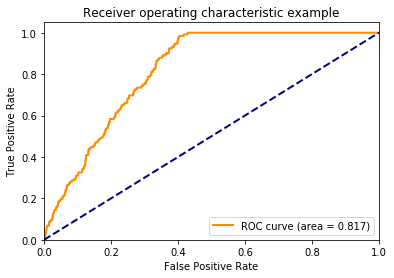

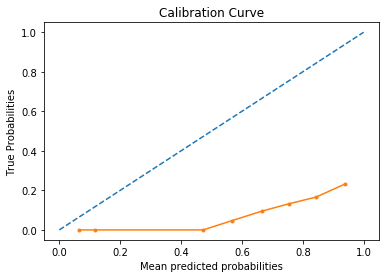

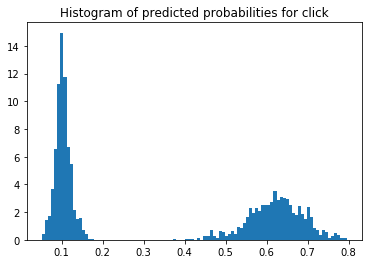

Accuracy: 0.9335
Recall: 0.0
Precision: 0.0
AUC: 0.8170604600609953


In [27]:

evaulate_pipeline(rf_pipe, X_val, y_val);

# Model 2: CatBoost 

In [28]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)
es_pool = Pool(data = X_es, label = y_es, cat_features=cat_features)


In [29]:
def make_catboost_pipe_line(train_pool, es_pool, class_weight = None, target_encoder = False, params = None):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    if params:
        model.set_params(**params)
    model.fit(train_pool, eval_set=es_pool, plot=True)
    return model


### Parameters being tuned:
1. min_child_samples  = the minimal number of observations in a new leaf that are required in order for creating it
2. depth              = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. l2_leaf_reg        = L2 regularization coeffecient  
4. n_estimators       = the totl number of trees in the forest
5. subsample          = proprtion of rows sampled in each tree growin


In [30]:
catboost_params_grid ={ 
                  'depth': [4,6,8] ,
                  'min_child_samples' : [100,500,1000],
                  'n_estimators': [100,200],
                  'subsample': [0.5,0.75,0.95],
                  'l2_leaf_reg':[3,1,5,10],
                       
                }
#find_best_params_catboost(catboost_params_grid, train_pool, es_pool, X_val, y_val)

In [31]:
model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               early_stopping_rounds = 20,
                               auto_class_weights = 'Balanced',
                               subsample= 0.5,
                               verbose=30)
search_results = model.randomized_search(catboost_params_grid,
                  train_pool,
                  y=None,
                  cv=3,
                  n_iter=10,
                  partition_random_seed=0,
                  calc_cv_statistics=True,
                  search_by_train_test_split=True,
                  refit=True,
                  shuffle=True,
                  stratified=None,
                  train_size=0.8,
                  verbose=False,
                  log_cout=sys.stdout,
                  log_cerr=sys.stderr)

0:	learn: 0.6584299	test: 0.6593911	best: 0.6593911 (0)	total: 91.2ms	remaining: 18.1s
30:	learn: 0.4544583	test: 0.4622254	best: 0.4622254 (30)	total: 898ms	remaining: 4.89s
60:	learn: 0.4403855	test: 0.4518670	best: 0.4518670 (60)	total: 1.64s	remaining: 3.73s
90:	learn: 0.4339904	test: 0.4487612	best: 0.4487612 (90)	total: 2.61s	remaining: 3.13s
120:	learn: 0.4289330	test: 0.4469058	best: 0.4469058 (120)	total: 3.55s	remaining: 2.32s
150:	learn: 0.4237688	test: 0.4460498	best: 0.4460498 (150)	total: 4.88s	remaining: 1.58s
180:	learn: 0.4182801	test: 0.4453017	best: 0.4452653 (174)	total: 6.21s	remaining: 652ms
199:	learn: 0.4154992	test: 0.4451933	best: 0.4451272 (188)	total: 6.85s	remaining: 0us

bestTest = 0.4451272237
bestIteration = 188

0:	learn: 0.6584299	test: 0.6593911	best: 0.6593911 (0)	total: 23.4ms	remaining: 2.31s
30:	learn: 0.4562179	test: 0.4630449	best: 0.4630449 (30)	total: 450ms	remaining: 1s
60:	learn: 0.4440628	test: 0.4524882	best: 0.4524882 (60)	total: 863ms	re

### optimized configuration for catboost

In [32]:
search_results['params']

{'min_data_in_leaf': 100,
 'depth': 6,
 'l2_leaf_reg': 1,
 'iterations': 200,
 'subsample': 0.95}

### Train a final cat boost model with the optimized params

In [33]:
catboost_pipe = make_catboost_pipe_line(train_pool, es_pool, target_encoder = False, params = search_results['params'])


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6199582	test: 0.6188905	best: 0.6188905 (0)	total: 52.4ms	remaining: 10.4s
30:	learn: 0.2517158	test: 0.2430808	best: 0.2430808 (30)	total: 530ms	remaining: 2.89s
60:	learn: 0.2050107	test: 0.1941010	best: 0.1941010 (60)	total: 1.31s	remaining: 2.99s
90:	learn: 0.1963374	test: 0.1875991	best: 0.1875991 (90)	total: 2.57s	remaining: 3.07s
120:	learn: 0.1929798	test: 0.1861858	best: 0.1861777 (119)	total: 3.79s	remaining: 2.48s
150:	learn: 0.1906316	test: 0.1856703	best: 0.1856683 (149)	total: 4.91s	remaining: 1.59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1856483125
bestIteration = 151

Shrink model to first 152 iterations.


Best Threshold: 0.2899000059465012 , with accuracy =  0.9335


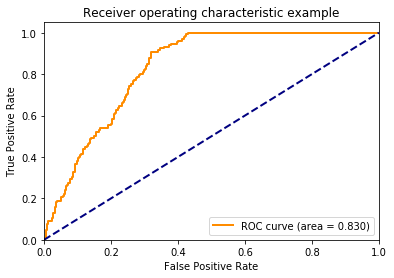

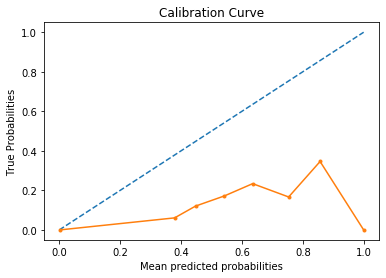

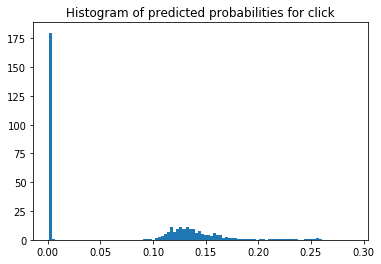

Accuracy: 0.9335
Recall: 0.0
Precision: 0.0
AUC: 0.8299712867432354


In [34]:
best_threshold_catboost = evaulate_pipeline(catboost_pipe, X_val, y_val)

# Model 3: KNN Classifier 

In [35]:
def make_knn_pipe_line(params = None) :
    encoder = ce.TargetEncoder(cols=cat_features)
    knn_model = KNeighborsClassifier(n_neighbors=300, weights='uniform')
    if params:
        knn_model.set_params(**params)
    return (Pipeline([('target_enc',encoder),  ('scaler',  StandardScaler()), ('KNN', knn_model)]))   

In [36]:
def find_best_params_knn(grid,X_train, y_train, X_val, y_val):
    best_accuracy = 0
    worst_accuracy = 1
    for g in ParameterGrid(grid):
        print(g)
        model = make_knn_pipe_line(params = g)
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_val)[:,1]
        curr_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_grid = g
            
        if curr_accuracy < worst_accuracy:
            worst_accuracy = curr_accuracy
            worst_grid = g
    print ("Final Result")
    print ("best accuracy", best_accuracy, ", Grid:", best_grid)
    print ("worst accuracy", worst_accuracy, ", Grid:", best_grid)
    return best_grid

### Parameters being tuned:
1. n_neighbors        = number of nearset neighbouring observation to consider for deciding on the prediciton
2. depweightsth       = should all neighbours have equal weight or weighted by the distance to the observation
3. leaf_size          = number of observations in the leafs of the tree that is used for finding the newarest neighbours



In [37]:
%%time

knn_params_grid ={'n_neighbors': [100, 500, 1000], 
                 'weights': ['uniform' , 'distance'],
                  'leaf_size' : [30,100]
                }
best_knn_params = find_best_params_knn(knn_params_grid, X_train, y_train, X_val, y_val)

{'leaf_size': 30, 'n_neighbors': 100, 'weights': 'uniform'}
Best Threshold: 0.34 , with accuracy =  0.933
{'leaf_size': 30, 'n_neighbors': 100, 'weights': 'distance'}
Best Threshold: 0.3943152116013133 , with accuracy =  0.9335
{'leaf_size': 30, 'n_neighbors': 500, 'weights': 'uniform'}
Best Threshold: 0.228 , with accuracy =  0.935
{'leaf_size': 30, 'n_neighbors': 500, 'weights': 'distance'}
Best Threshold: 0.24545975920225008 , with accuracy =  0.9345
{'leaf_size': 30, 'n_neighbors': 1000, 'weights': 'uniform'}
Best Threshold: 0.2 , with accuracy =  0.935
{'leaf_size': 30, 'n_neighbors': 1000, 'weights': 'distance'}
Best Threshold: 0.21606933955513952 , with accuracy =  0.935
{'leaf_size': 100, 'n_neighbors': 100, 'weights': 'uniform'}
Best Threshold: 0.34 , with accuracy =  0.933
{'leaf_size': 100, 'n_neighbors': 100, 'weights': 'distance'}
Best Threshold: 0.3943152116013133 , with accuracy =  0.9335
{'leaf_size': 100, 'n_neighbors': 500, 'weights': 'uniform'}
Best Threshold: 0.228 

In [38]:
knn_pipeline = make_knn_pipe_line(params = best_knn_params)
knn_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=['app_cat', 'banner_pos', 'state',
                                     'Day_of_Week', 'Month', 'hour',
                                     'device_version', 'manufacturer'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=500, p=2,
                                      weights='uniform'))],
         verbose=False)

Best Threshold: 0.228 , with accuracy =  0.935


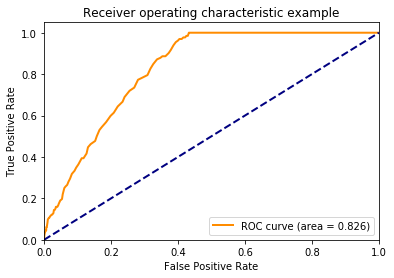

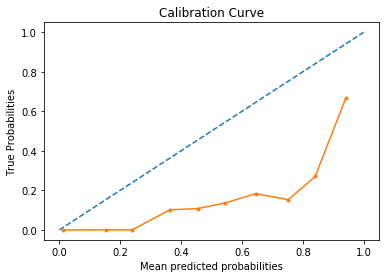

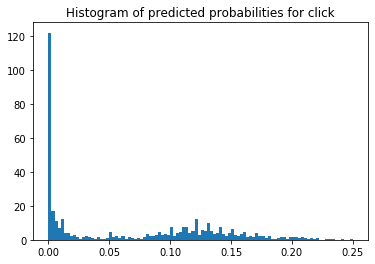

Accuracy: 0.935
Recall: 0.030303030303030304
Precision: 0.6666666666666666
AUC: 0.8258224644734281


0.228

In [39]:
evaulate_pipeline(knn_pipeline, X_val, y_val);

# Exaplinable AI:  Shap Values

In [40]:
model = catboost_pipe


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


Shap Values (Shapely Additive exPlanations is a model Agnostic method for explaining model predictions
It is based on theory developed by Loid Shapley in the 1950's 

## Shap Summary Plot

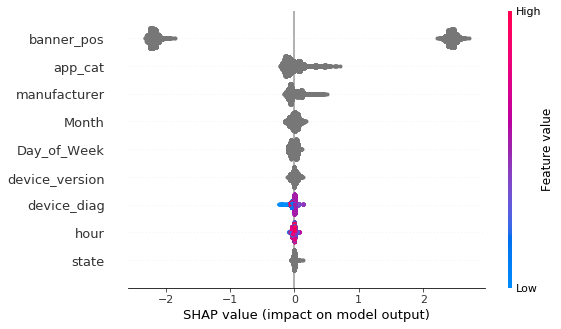

In [41]:

shap.summary_plot(shap_values)

#### explanation
This graph is actually a series of dot-plots:every observation(row) is representated as a dot
for each variable in the model we have a dot-plot showing a dot for each observation in the train set
X-axis: The shap value i.e. the negative or positive contribution of the observation's variable to the final prediction
Y-axis: in case where many observation have the same shap value the dots are stacked vertically
Color: For continuous variables the color represent whether the value of the variable is high or low in the observation

##### Example:
in the device_diag variable we see that large screens (strong red) are associated with increased (positive) probability for a click

In [42]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(explainer.expected_value,shap_values , data, link='logit'))

# 3 random predictions local explanations

In [43]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [44]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [45]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

# Section 8: Prediction on external data set

In [46]:
model = catboost_pipe

In [47]:
testset = pd.read_csv("ctr_dataset_test.csv")

In [48]:
test_df = add_features(testset)

In [49]:
X_test  = test_df[features]


In [50]:
y_hat = model.predict_proba(X_test)

In [51]:
y_pred = (y_hat[:,1] >= best_threshold_catboost).astype(int)
predictions = pd.Series(y_pred)

#### Total predictions , total clicks predicted,  Percentage of predicted clicks:

In [52]:
f"N={predictions.count()}, Clicks={predictions.sum()}, Clicks Percent= {round(predictions.mean()*100,3)}%"

'N=629764, Clicks=115, Clicks Percent= 0.018%'

# Group 8 output

In [53]:
predictions.to_csv('output_8.txt', index=False)

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
